# EDA for CHGH dataset

In [1]:
!nvidia-smi

Sat May 13 12:56:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup Environment

In [2]:
import matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

## Import Library

In [3]:
import sys
import os
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary, DataLoader
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SqueezeDimd,
    LabelFilterd,
    MapLabelValued
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.data_loader_utils import load_data_dict_json, split_data_dicts
from datasets.chgh_dataset import get_data_dicts
from datasets.label_dataset import get_multiple_label_data_dicts, multi_label_to_label_pred_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info, get_pids_by_data_dicts
from data_utils.io import load_json, save_json
from expers.preprocess import get_rel_data_dicts

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data dicts

In [5]:
# # mmwhs data dict json
from pprint import pprint
from datasets.mmwhs_dataset import get_data_dicts

def get_data_by_idxs(data_dicts, idxs):
    return get_rel_data_dicts([data_dicts[i] for i in idxs])

data_dicts_dir = os.path.join('/nfs/Workspace/CardiacSeg', 'exps', 'data_dicts', 'mmwhs')
data_dicts_json = os.path.join(data_dicts_dir, 'exp_2.json')
data_dir = '/nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train'

data_dicts = get_data_dicts(data_dir)
pids = get_pids_by_data_dicts(data_dicts)
tr_ds, val_ds, tt_ds = split_data_dicts(data_dicts, fold=4, num_fold=5, split_train_ratio=0.75)

out_data_dicts = {
    'train' : get_rel_data_dicts(tr_ds),
    'val' : get_rel_data_dicts(val_ds),
    'test' : get_rel_data_dicts(tt_ds)
}

pprint(out_data_dicts)
# os.makedirs(data_dicts_dir, exist_ok=True)
# save_json(out_data_dicts, data_dicts_json)

fold: 4
train files (12): ['ct_train_1001_image', 'ct_train_1002_image', 'ct_train_1003_image', 'ct_train_1004_image', 'ct_train_1005_image', 'ct_train_1006_image', 'ct_train_1007_image', 'ct_train_1008_image', 'ct_train_1009_image', 'ct_train_1010_image', 'ct_train_1011_image', 'ct_train_1012_image']
val files (3): ['ct_train_1013_image', 'ct_train_1014_image', 'ct_train_1015_image']
test files (5): ['ct_train_1016_image', 'ct_train_1017_image', 'ct_train_1018_image', 'ct_train_1019_image', 'ct_train_1020_image']
{'test': [{'image': 'ct_train/ct_train_1016_image.nii.gz',
           'label': 'ct_train/ct_train_1016_label.nii.gz'},
          {'image': 'ct_train/ct_train_1017_image.nii.gz',
           'label': 'ct_train/ct_train_1017_label.nii.gz'},
          {'image': 'ct_train/ct_train_1018_image.nii.gz',
           'label': 'ct_train/ct_train_1018_label.nii.gz'},
          {'image': 'ct_train/ct_train_1019_image.nii.gz',
           'label': 'ct_train/ct_train_1019_label.nii.gz'},
    

## Show data info

In [6]:
data_dicts_json =  '/nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/exp_1.json'
data_dir = '/nfs/Workspace/CardiacSeg/dataset/mmwhs'
tr_ds, val_ds, tt_ds = load_data_dict_json(data_dir, data_dicts_json)
ds = [*tr_ds] #, *val_ds, *tt_ds]

load json from /nfs/Workspace/CardiacSeg/exps/data_dicts/mmwhs/exp_1.json
train files (12): ['ct_train_1001_image', 'ct_train_1002_image', 'ct_train_1003_image', 'ct_train_1004_image', 'ct_train_1005_image', 'ct_train_1006_image', 'ct_train_1007_image', 'ct_train_1008_image', 'ct_train_1009_image', 'ct_train_1010_image', 'ct_train_1011_image', 'ct_train_1012_image']
val files (3): ['ct_train_1013_image', 'ct_train_1014_image', 'ct_train_1015_image']
test files (5): ['ct_train_1016_image', 'ct_train_1017_image', 'ct_train_1018_image', 'ct_train_1019_image', 'ct_train_1020_image']


pid: ct_train_1001_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1001_image.nii.gz
img shape: [512, 512, 363]
img spacing: [0.35546875, 0.35546875, 0.45]
lbl shape: [512, 512, 363]
lbl spacing: [0.35546875, 0.35546875, 0.45]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


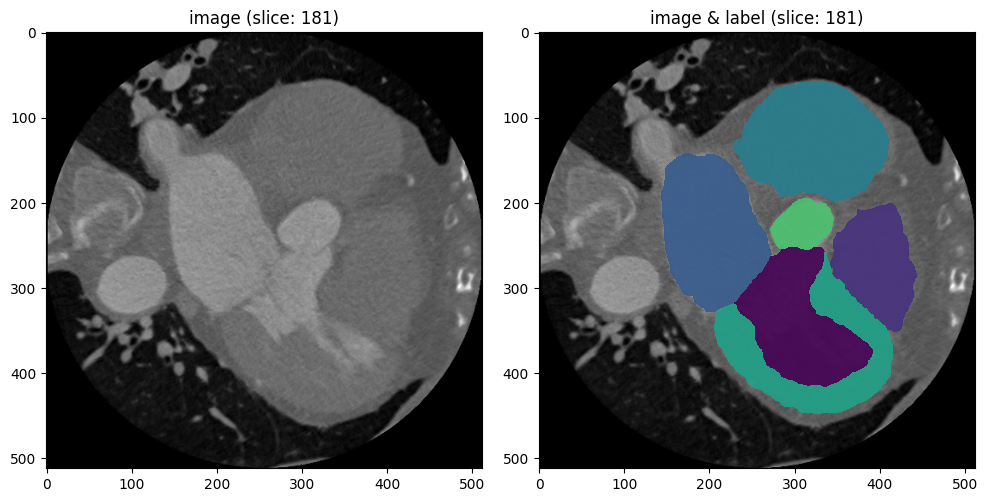

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1002_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1002_image.nii.gz
img shape: [512, 512, 239]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 239]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


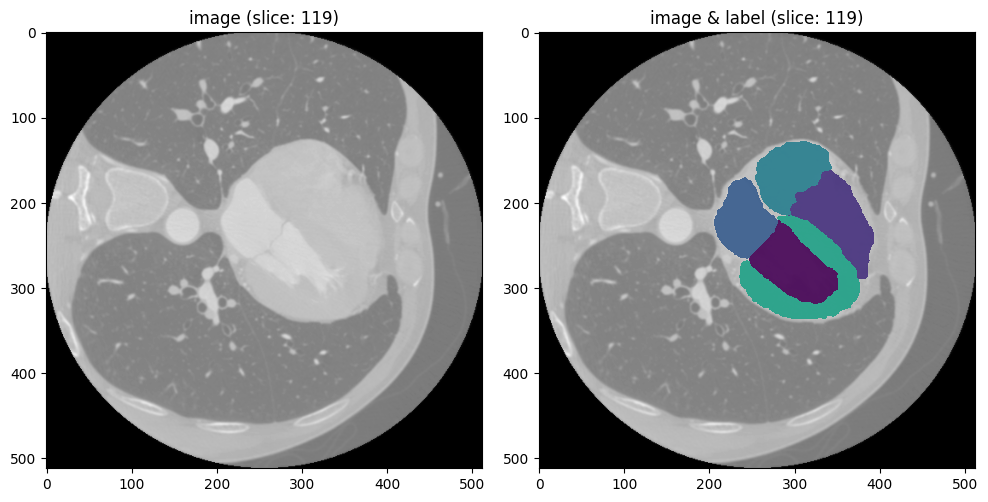

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1003_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1003_image.nii.gz
img shape: [512, 512, 298]
img spacing: [0.30273438, 0.30273438, 0.45]
lbl shape: [512, 512, 298]
lbl spacing: [0.30273438, 0.30273438, 0.45]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


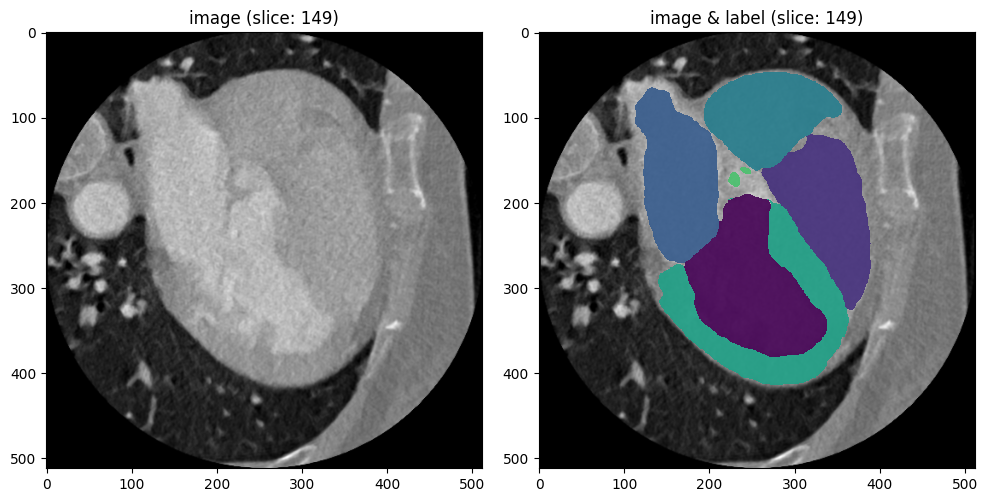

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1004_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1004_image.nii.gz
img shape: [512, 512, 200]
img spacing: [0.320312, 0.320312, 0.625]
lbl shape: [512, 512, 200]
lbl spacing: [0.320312, 0.320312, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


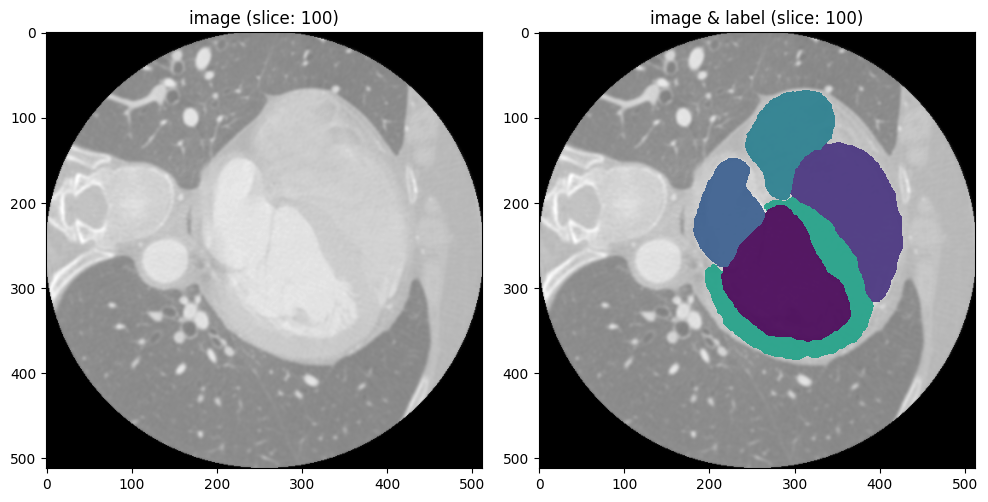

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1005_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1005_image.nii.gz
img shape: [512, 512, 177]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 177]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


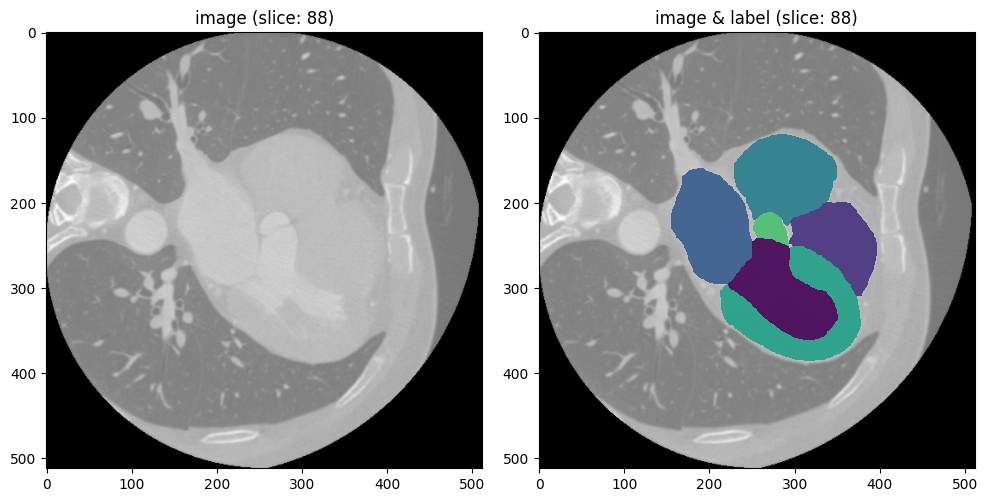

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1006_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1006_image.nii.gz
img shape: [512, 512, 248]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 248]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


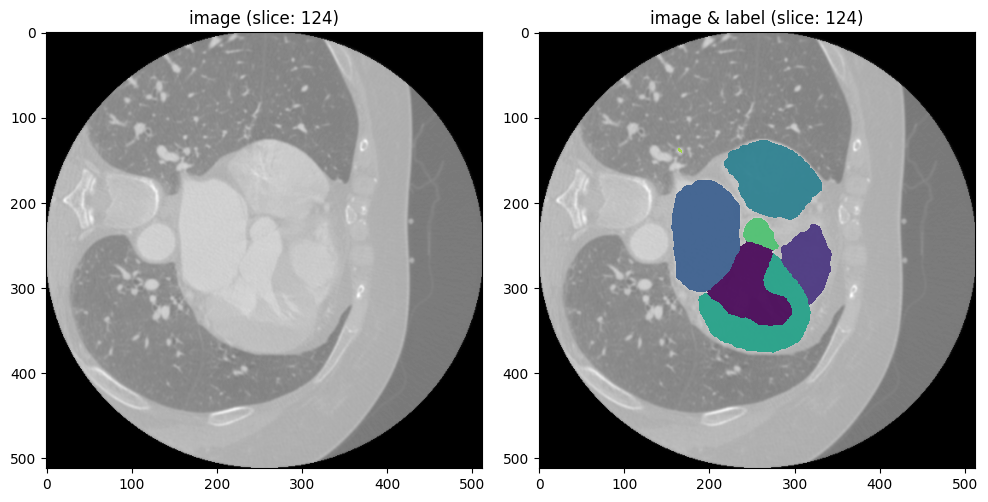

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1007_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1007_image.nii.gz
img shape: [512, 512, 243]
img spacing: [0.435547, 0.435547, 0.625]
lbl shape: [512, 512, 243]
lbl spacing: [0.435547, 0.435547, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


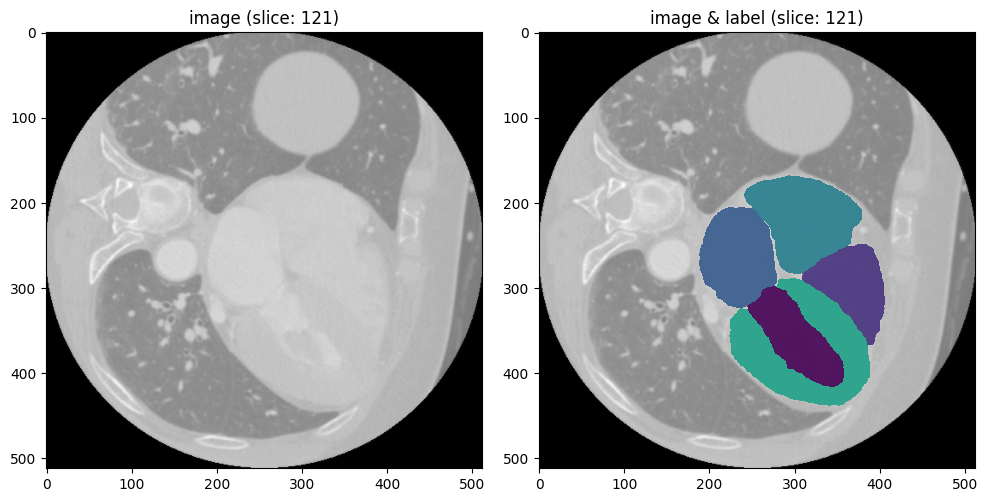

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1008_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1008_image.nii.gz
img shape: [512, 512, 222]
img spacing: [0.4375, 0.4375, 0.625]
lbl shape: [512, 512, 222]
lbl spacing: [0.4375, 0.4375, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


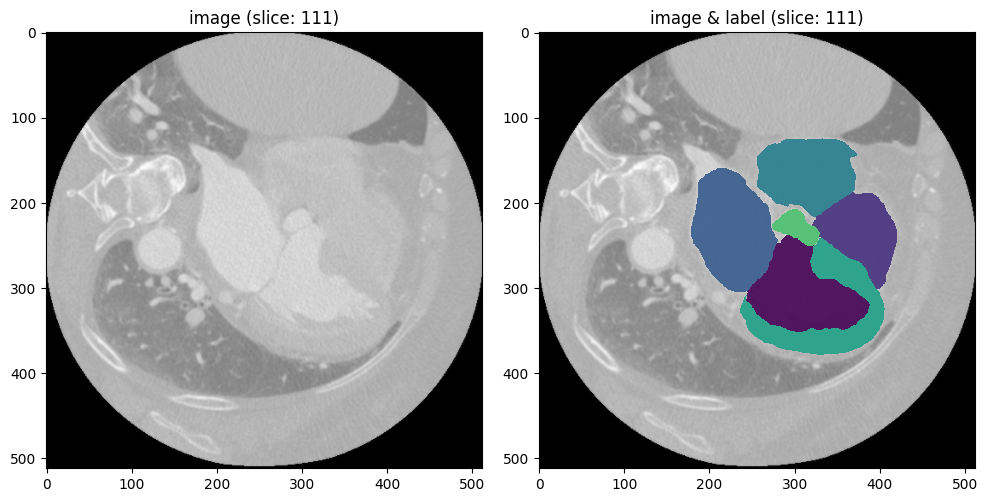

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1009_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1009_image.nii.gz
img shape: [512, 512, 293]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 293]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


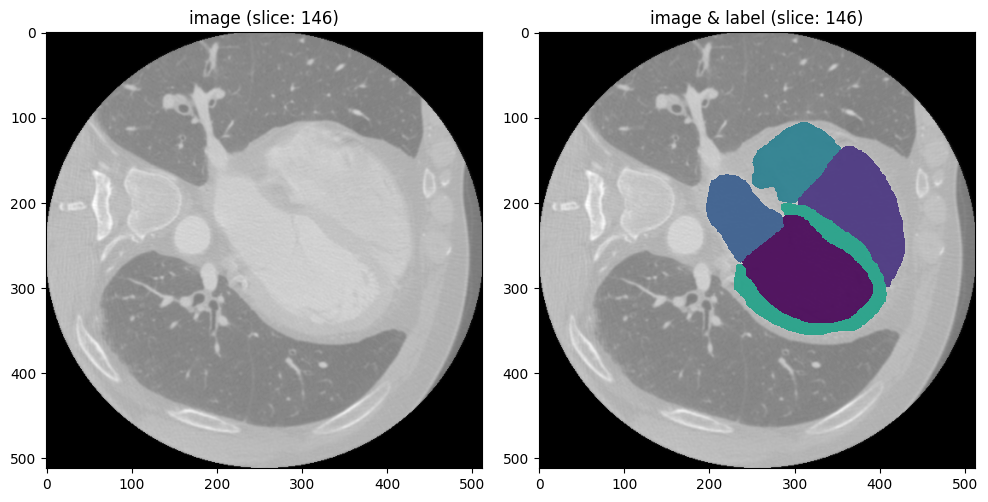

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1010_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1010_image.nii.gz
img shape: [512, 512, 274]
img spacing: [0.505859, 0.505859, 0.625]
lbl shape: [512, 512, 274]
lbl spacing: [0.505859, 0.505859, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


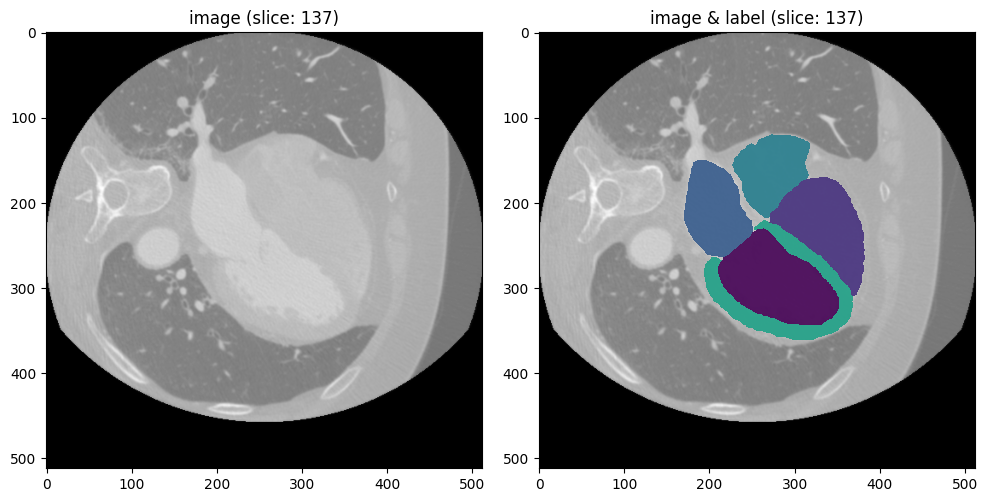

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1011_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1011_image.nii.gz
img shape: [512, 512, 239]
img spacing: [0.388672, 0.388672, 0.625]
lbl shape: [512, 512, 239]
lbl spacing: [0.388672, 0.388672, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


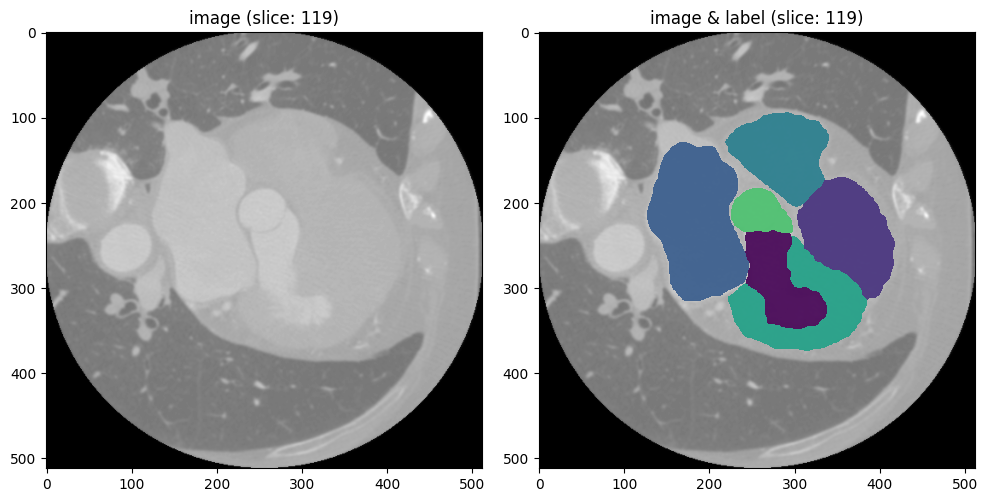

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1012_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1012_image.nii.gz
img shape: [512, 512, 177]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 177]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [0. 1. 2. 3. 4. 5. 6. 7.]


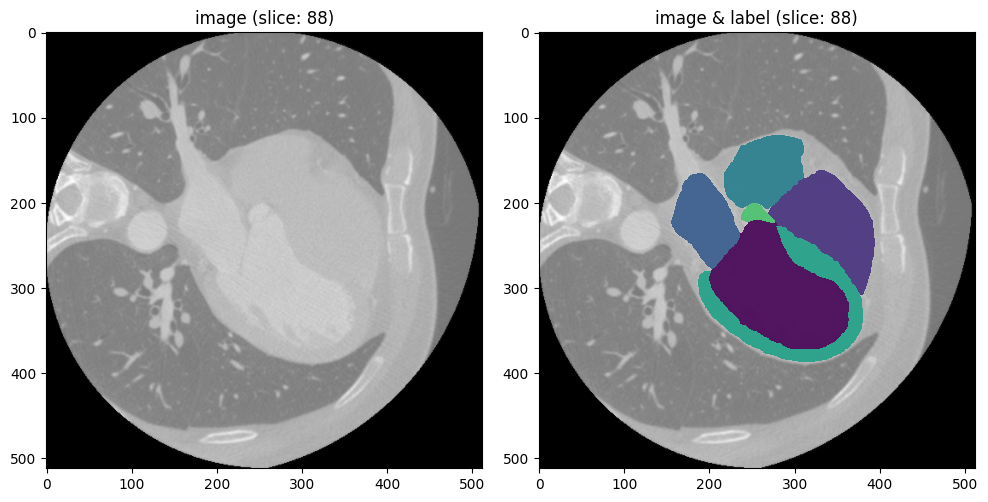

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [7]:
base_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    LabelFilterd(keys=["label"], applied_labels=[500, 600, 420, 550, 205, 820, 850]),
    MapLabelValued(
        keys=["label"], 
        orig_labels=[0, 500, 600, 420, 550, 205, 820, 850],
        target_labels=[0, 1, 2, 3, 4, 5, 6, 7]
    ),
])
data_info_df = get_data_info(ds, base_transforms)

In [8]:
data_info_df

pid        img_shape                       img_space  \
0   ct_train_1001_image  [512, 512, 363]  [0.35546875, 0.35546875, 0.45]   
1   ct_train_1002_image  [512, 512, 239]     [0.488281, 0.488281, 0.625]   
2   ct_train_1003_image  [512, 512, 298]  [0.30273438, 0.30273438, 0.45]   
3   ct_train_1004_image  [512, 512, 200]     [0.320312, 0.320312, 0.625]   
4   ct_train_1005_image  [512, 512, 177]     [0.488281, 0.488281, 0.625]   
5   ct_train_1006_image  [512, 512, 248]     [0.488281, 0.488281, 0.625]   
6   ct_train_1007_image  [512, 512, 243]     [0.435547, 0.435547, 0.625]   
7   ct_train_1008_image  [512, 512, 222]         [0.4375, 0.4375, 0.625]   
8   ct_train_1009_image  [512, 512, 293]     [0.488281, 0.488281, 0.625]   
9   ct_train_1010_image  [512, 512, 274]     [0.505859, 0.505859, 0.625]   
10  ct_train_1011_image  [512, 512, 239]     [0.388672, 0.388672, 0.625]   
11  ct_train_1012_image  [512, 512, 177]     [0.488281, 0.488281, 0.625]   

          lbl_shape                       lbl_space  \
0   [512, 512, 363]  [0.35546875, 0.35546875, 0.45]   
1   [512, 512, 239]     [0.488281, 0.488281, 0.625]   
2   [512, 512, 298]  [0.30273438, 0.30273438, 0.45]   
3   [512, 512, 200]     [0.320312, 0.320312, 0.625]   
4   [512, 512, 177]     [0.488281, 0.488281, 0.625]   
5   [512, 512, 248]     [0.488281, 0.488281, 0.625]   
6   [512, 512, 243]     [0.435547, 0.435547, 0.625]   
7   [512, 512, 222]         [0.4375, 0.4375, 0.625]   
8   [512, 512, 293]     [0.488281, 0.488281, 0.625]   
9   [512, 512, 274]     [0.505859, 0.505859, 0.625]   
10  [512, 512, 239]     [0.388672, 0.388672, 0.625]   
11  [512, 512, 177]     [0.488281, 0.488281, 0.625]   

                                     lbl_ids  
0   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
1   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
2   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
3   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
4   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
5   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
6   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
7   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
8   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
9   [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
10  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  
11  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [9]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
print('min:', data_shape_df.min().to_list())
print('max:',data_shape_df.max().to_list())
print('mean:',data_shape_df.mean().to_list())

min: [512, 512, 177]
max: [512, 512, 363]
mean: [512.0, 512.0, 247.75]


In [10]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])

min_z = data_space_df[['z']].min().values[0]
max_z = data_space_df[['z']].max().values[0]

min_z_df = data_space_df.loc[data_space_df['z'] == min_z]
max_z_df = data_space_df.loc[data_space_df['z'] == max_z]

print('sp xyz mean:',data_space_df.mean().to_list())
print('sp min xy min z:', min_z_df.min().to_list())
print('sp max xy min z:', min_z_df.max().to_list())
print('sp min xy max z:', max_z_df.min().to_list())
print('sp max xy max z:', max_z_df.max().to_list())

sp xyz mean: [0.43229150772094727, 0.43229150772094727, 0.5958333611488342]
sp min xy min z: [0.302734375, 0.302734375, 0.44999998807907104]
sp max xy min z: [0.35546875, 0.35546875, 0.44999998807907104]
sp min xy max z: [0.3203119933605194, 0.3203119933605194, 0.625]
sp max xy max z: [0.5058590173721313, 0.5058590173721313, 0.625]


## Statcics

In [11]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=tr_ds,
    transform=base_tf
)

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
Loading dataset: 100%|██████████| 12/12 [00:47<00:00,  3.96s/it]


In [12]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles(min_percentile=0.1,max_percentile=99.9)
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [13]:
print('data target space:')
data_target_space

data target space:


(0.46289050579071045, 0.46289050579071045, 0.625)

In [14]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


min    med     max        mean         std  min_percentile (0.5%)  \
0 -955.0  227.0  1354.0  268.685394  159.645386                  -70.0   

   max_percentile (99.5%)  
0                   677.0

## Transform

In [13]:
space = [1.0,1.0,1.0]
a_min = -70 #s.data_min_percentile
a_max = 677 #s.data_max_percentile
transform = Compose(
      [
          LoadImaged(keys=["image", "label"]),
          AddChanneld(keys=["image", "label"]),
          Orientationd(keys=["image", "label"], axcodes="RAS"),
          Spacingd(
              keys=["image", "label"],
              pixdim=space,
              mode=("bilinear", "nearest"),
          ),
          ScaleIntensityRanged(
              keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True
          ),
          SqueezeDimd(keys=["image", "label"]),
          ToTensord(keys=["image", "label"])
      ]
  )

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


pid: ct_train_1001_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1001_image.nii.gz
img shape: [512, 512, 363]
img spacing: [0.35546875, 0.35546875, 0.45]
lbl shape: [512, 512, 363]
lbl spacing: [0.35546875, 0.35546875, 0.45]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


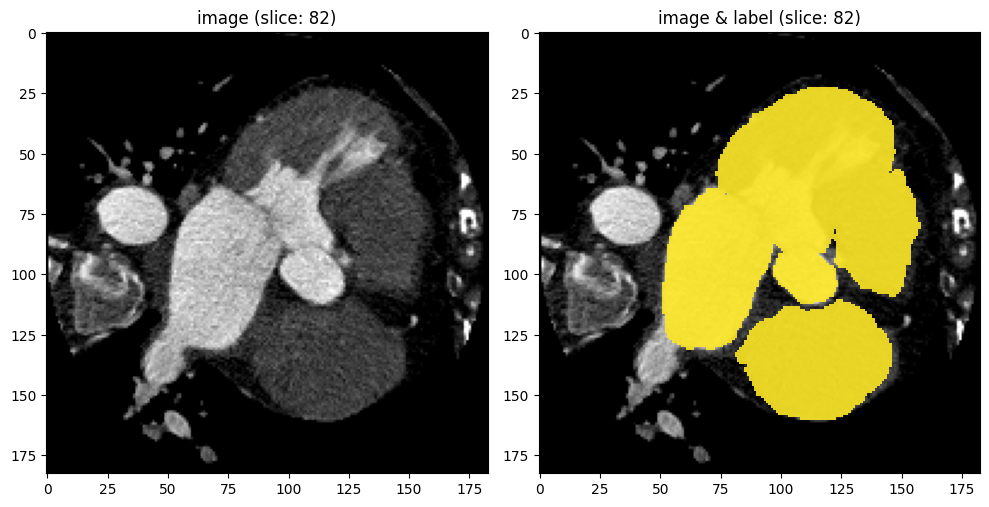

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1002_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1002_image.nii.gz
img shape: [512, 512, 239]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 239]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


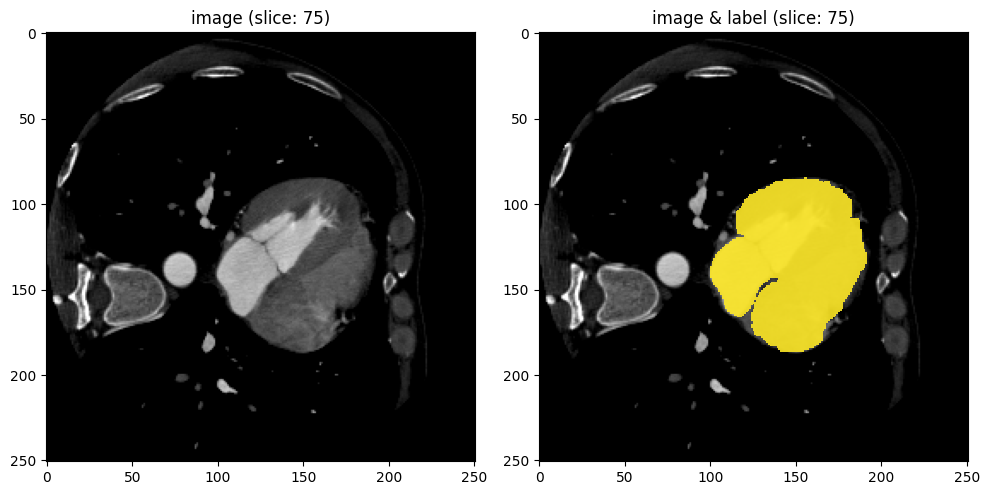

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1003_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1003_image.nii.gz
img shape: [512, 512, 298]
img spacing: [0.30273438, 0.30273438, 0.45]
lbl shape: [512, 512, 298]
lbl spacing: [0.30273438, 0.30273438, 0.45]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


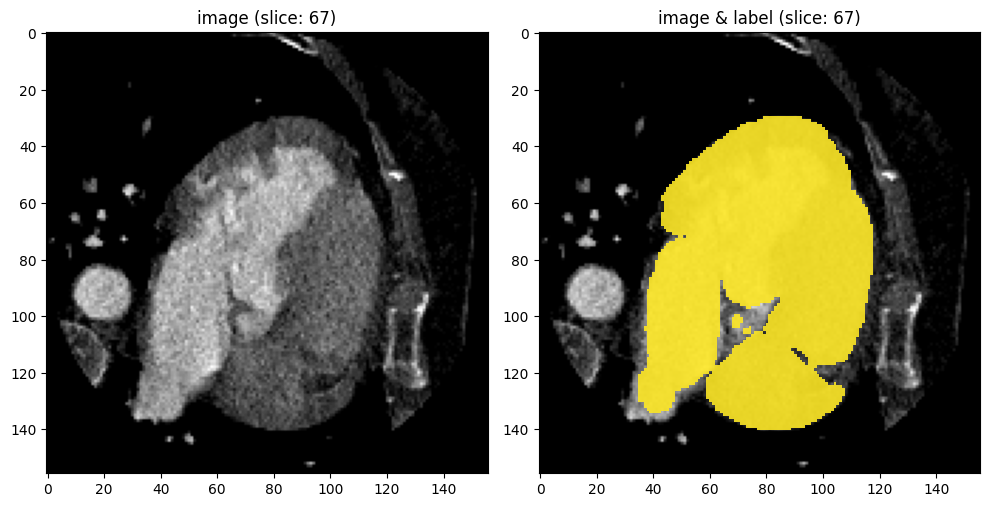

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1004_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1004_image.nii.gz
img shape: [512, 512, 200]
img spacing: [0.320312, 0.320312, 0.625]
lbl shape: [512, 512, 200]
lbl spacing: [0.320312, 0.320312, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


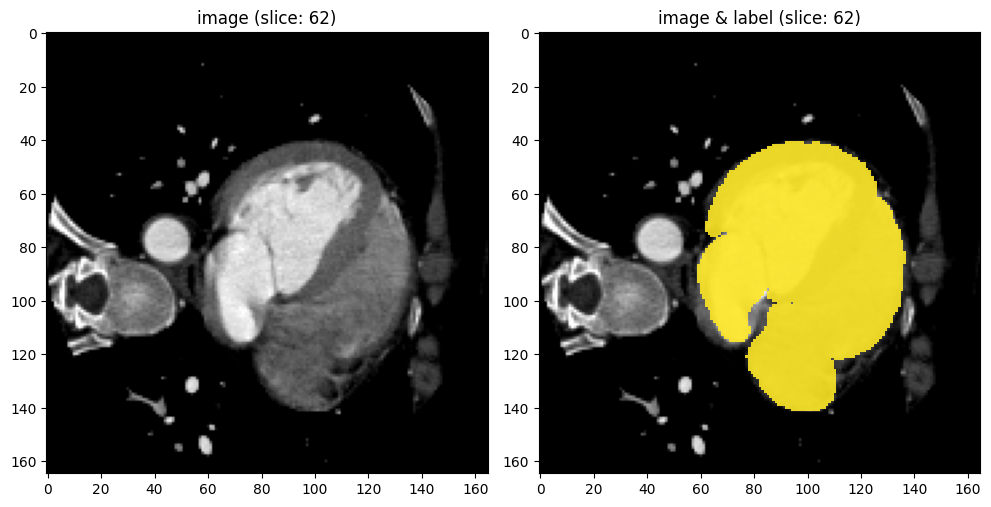

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1005_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1005_image.nii.gz
img shape: [512, 512, 177]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 177]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


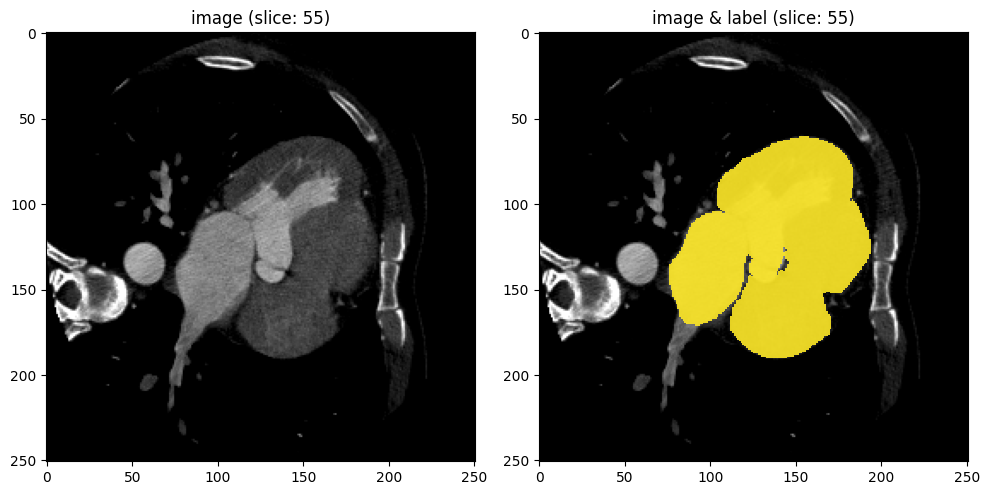

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1006_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1006_image.nii.gz
img shape: [512, 512, 248]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 248]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


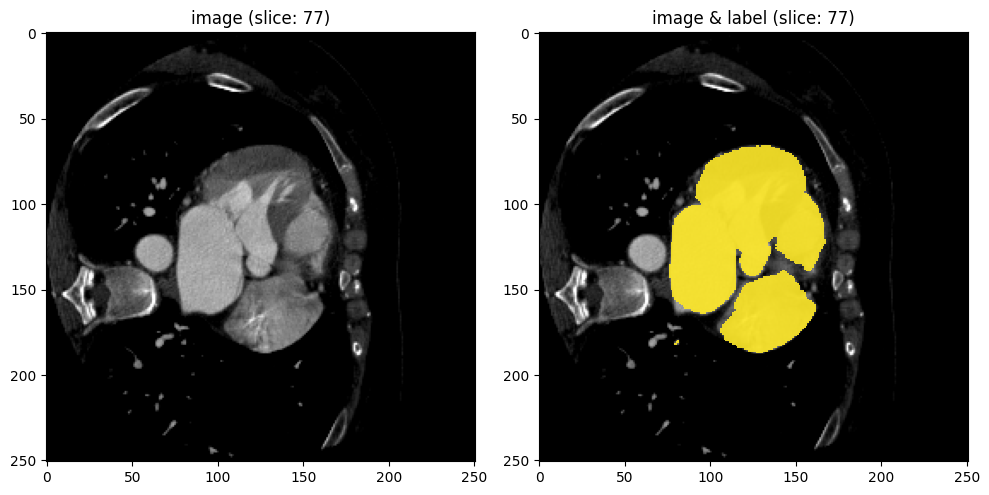

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1007_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1007_image.nii.gz
img shape: [512, 512, 243]
img spacing: [0.435547, 0.435547, 0.625]
lbl shape: [512, 512, 243]
lbl spacing: [0.435547, 0.435547, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


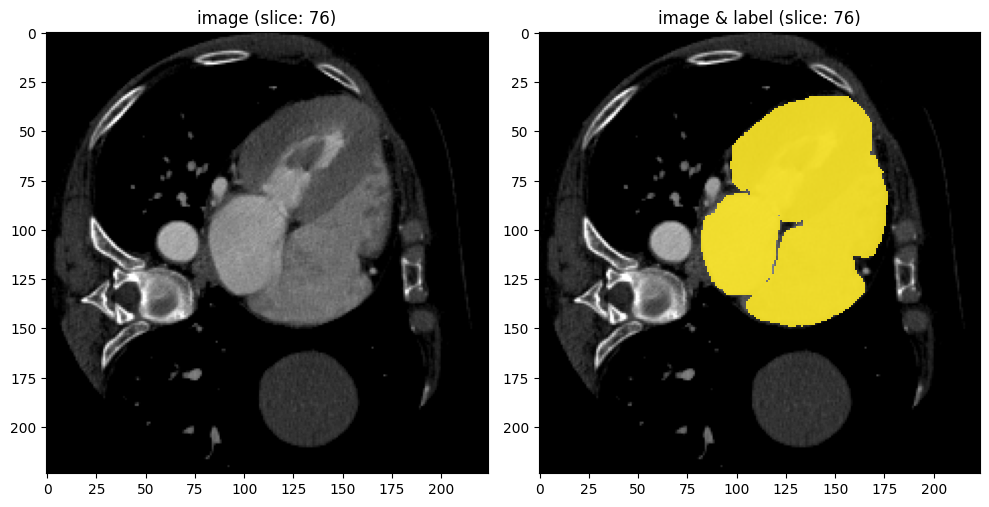

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1008_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1008_image.nii.gz
img shape: [512, 512, 222]
img spacing: [0.4375, 0.4375, 0.625]
lbl shape: [512, 512, 222]
lbl spacing: [0.4375, 0.4375, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


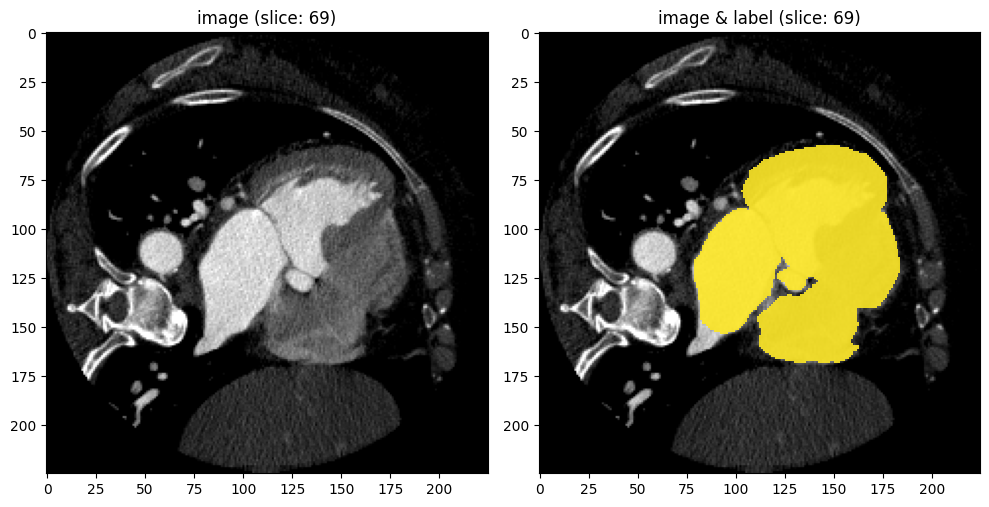

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1009_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1009_image.nii.gz
img shape: [512, 512, 293]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 293]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


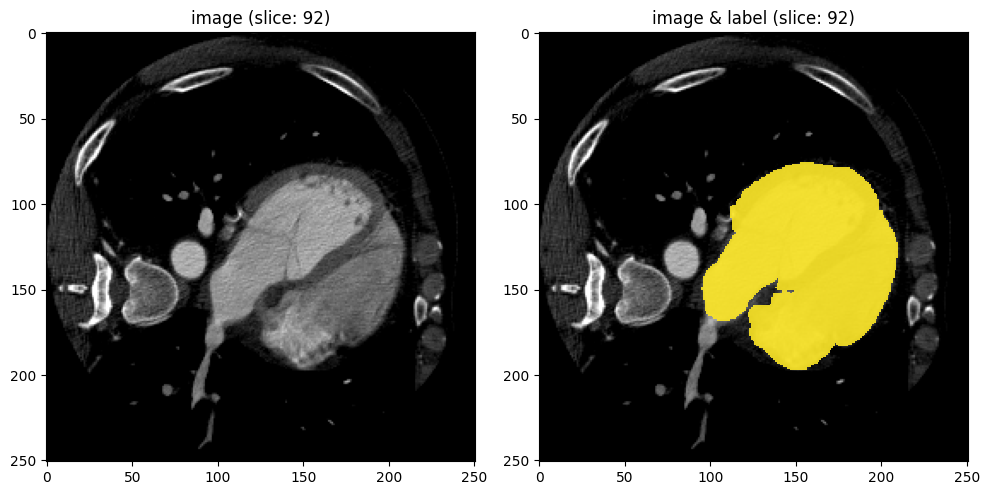

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1010_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1010_image.nii.gz
img shape: [512, 512, 274]
img spacing: [0.505859, 0.505859, 0.625]
lbl shape: [512, 512, 274]
lbl spacing: [0.505859, 0.505859, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


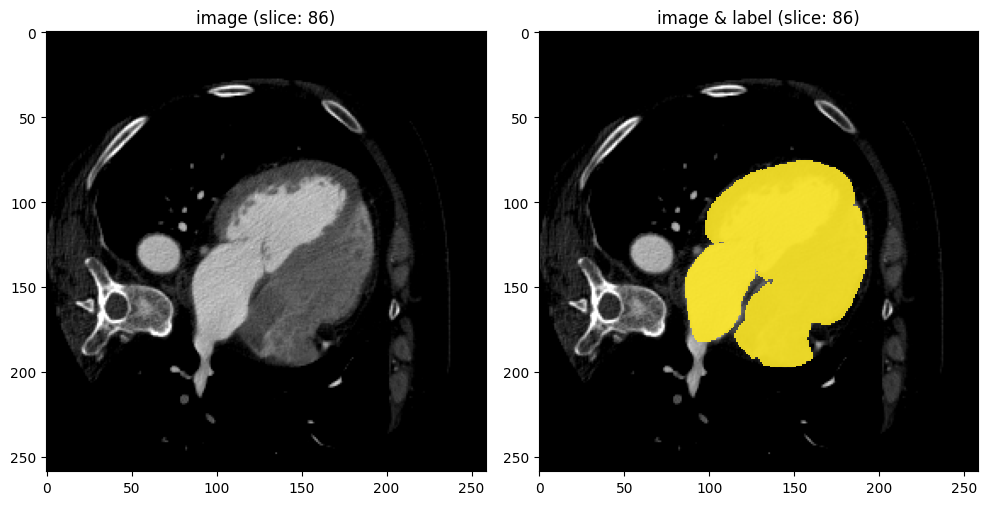

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1011_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1011_image.nii.gz
img shape: [512, 512, 239]
img spacing: [0.388672, 0.388672, 0.625]
lbl shape: [512, 512, 239]
lbl spacing: [0.388672, 0.388672, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


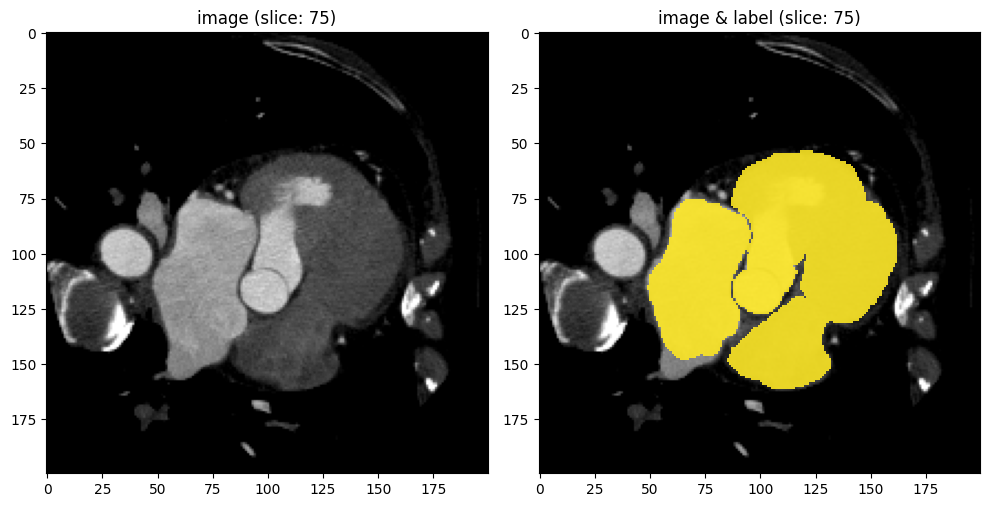

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



pid: ct_train_1012_image
file_pth: /nfs/Workspace/CardiacSeg/dataset/mmwhs/ct_train/ct_train_1012_image.nii.gz
img shape: [512, 512, 177]
img spacing: [0.488281, 0.488281, 0.625]
lbl shape: [512, 512, 177]
lbl spacing: [0.488281, 0.488281, 0.625]
lbl ids: [  0. 205. 420. 500. 550. 600. 820. 850.]


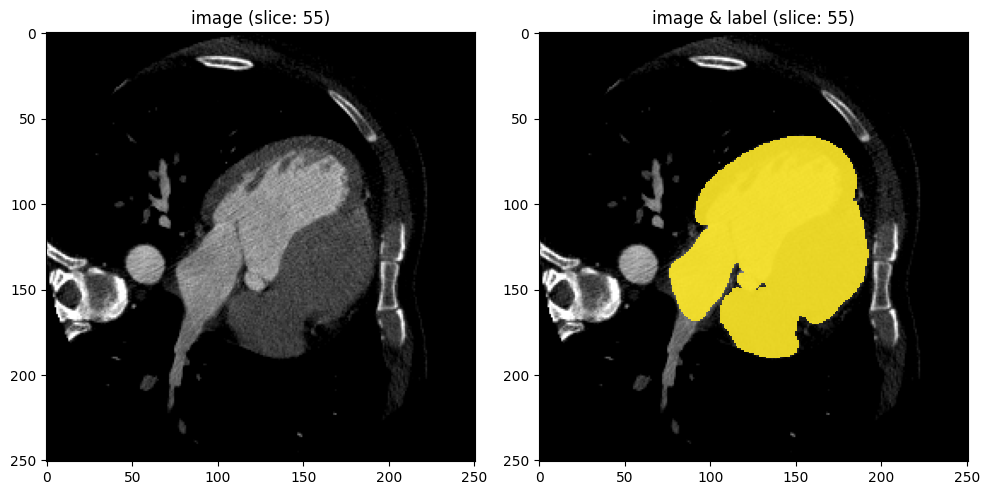

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [14]:
data_info_df = get_data_info(tr_ds, transform)